In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import numba as nb

/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# Constants used as shorthand to make the code barely legible
R = 16**0 # team 1
G = 16**1 # team 2
B = 16**2 # team 3
E = 16**3 # empty
V = 16**4 # blocked / void

# define color map 
color_map = {R: np.array([234,  67,  53]), # red
             G: np.array([ 52, 168,  83]), # green
             B: np.array([ 66, 133, 244]), # blue
             E: np.array([200, 215, 244]), # white
             V: np.array([  0,   0,   0])} # black

In [3]:

@nb.njit
def sameness( grid, me, i, j ):
    
    N = grid.shape[0]
    
    up = (i+1) % N
    dw = (i-1) % N
    lx = (j+1) % N
    rx = (j-1) % N
    
    nn  = grid[dw,lx]
    nn += grid[dw,j ]
    nn += grid[dw,rx]
    nn += grid[i ,lx]
    nn += grid[i ,rx]
    nn += grid[up,lx]
    nn += grid[up,j ]
    nn += grid[up,rx]
    
    Rness  = (nn // R ) % 16
    Gness  = (nn // G ) % 16
    Bness  = (nn // B ) % 16
    Eness  = (nn // E ) % 16

    if me == R:
        my_sameness = (Rness-Gness-Bness-Eness/2) / 8
    if me == G:
        my_sameness = (Gness-Rness-Bness-Eness/2) / 8
    if me == B:
        my_sameness = (Bness-Rness-Gness-Eness/2) / 8
        
    return my_sameness

@nb.njit
def evolve( grid, THR, ij, scatter ):
    N = grid.shape[0]
    swapped = 0
    tries = 0
    ntries = len(ij) // 2
    for _ in range(ntries):
        
        i = ij[tries+0]
        j = ij[tries+1]
        me = grid[i,j]

        if me in [R,G,B]:
            my_sameness = sameness( grid, me, i, j )
            if my_sameness < THR:
                dx = scatter[tries+0]
                dy = scatter[tries+1]
                ni = (i+dx) % N
                nj = (j+dy) % N
                if grid[ni,nj] == E:
                    if sameness( grid, me, ni, nj ) > my_sameness:
                        grid[i,j] = E
                        grid[ni,nj] = me
                        swapped += 1
        tries += 2
    return swapped

def show(grid, color_map, iw):
    
    N = grid.shape[0]
    
    if iw >= 0 :
        fig = plt.figure(figsize=(5,5))
        data_3d = np.ndarray(shape=(N,N, 3), dtype=int)
        for i in range(N):
            for j in range(N):
                data_3d[i][j] = color_map[grid[i][j]]
        plt.imshow(data_3d)
        plt.show()
        
        if iw >= 1 :
            plt.imshow(grid)
            plt.show()

    if iw >= 1 :
        S = np.zeros((N,N))
        tmp = np.zeros(8, dtype=int)
        for i in range(N):
            for j in range(N):
                S[i,j] = sameness( grid, grid[i,j], i,j)

        plt.imshow(S)
        plt.show()

    if iw >= 2 :
        print( Counter(grid.flatten()[:]) )
        plt.hist(S.flatten(), bins=N)
        plt.show()

In [4]:
def expand_cluster( grid, cluster, i, j ):
    N = grid.shape[0]
    cluster_size = 0
    for di in [-1,0,1]:
        for dj in [-1,0,1]:
            
            ni = (i+di)%N
            nj = (j+dj)%N
            
            if cluster[ni,nj] == 0 and grid[ni,nj] == grid[i,j]:
                cluster[ni,nj] = cluster[i,j]
                cluster_size += 1
#                print( 'adding', ni,nj, 'to cluster', cluster[i,j] )
                cluster_size += expand_cluster( grid, cluster, ni,nj)
    
    return cluster_size
                        


def make_cluster( grid ):
    
    N = grid.shape[0]
    cluster = np.zeros_like(grid)
    cluster_list = np.random.choice(N*N, N*N) + 1
    
    cluster_index = 0
    cluster_sizes = []
    for i in range(N):
        for j in range(N):
            
            if grid[i,j] in [R,G,B]:
                if cluster[i,j] == 0:
                    cluster[i,j] = cluster_list[cluster_index]
                    cluster_size = 1
                    cluster_index += 1
    #                print( 'new cluster', cluster[i,j], 'at', i,j, 'of type', grid[i,j] )

                    cluster_size += expand_cluster( grid, cluster, i,j )
            
                    cluster_sizes.append(cluster_size)
                        
    return cluster, cluster_sizes

In [5]:
def create_grid( N, THR, p, seed, iw=-1 ):
    max_evolutions = N
    ntries = N*N*N

    rng_sd = np.random.default_rng(seed)
    seed_1 = rng_sd.integers(0,100)
    seed_2 = rng_sd.integers(0,100)
    seed_3 = rng_sd.integers(0,100)
    rng_st = np.random.default_rng(seed_1)
    rng_ij = np.random.default_rng(seed_2)
    rng_sc = np.random.default_rng(seed_3)
    
    grid = np.zeros((N,N), int)
    for i in range(N):
        for j in range(N):
            r = rng_st.choice([R,G,B,E,V], 1, p=p)[0]
            grid[i,j] = r
    show(grid, color_map, iw-1)
    
    S = N
    evolutions = 0
    while True:

        ij      = rng_ij.choice(N  , size=2*ntries)
        scatter = rng_sc.choice(S+1, size=2*ntries) - S // 2

        swapped = evolve( grid, THR, ij, scatter )

        if swapped < N:
            S //= 1.4
            S = int(S)

        evolutions += 1
        if S == 0 or evolutions >= max_evolutions:
            break

    show(grid, color_map, iw)
    
    c,s = make_cluster(grid)
    
    if iw >= 1:
        plt.imshow(grid)
        plt.show()
        plt.imshow(c)
        plt.show()
    
    return grid, c, s

In [6]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [31]:
def create_cluster_sizes( Nlist, THR, p, seed, Nrep=None):
    all_all_cluster_sizes = {}
    
    rng_sd = np.random.default_rng(seed)
    
    if not isinstance(Nlist, list):
        Nlist = [Nlist]
        
    for N in Nlist:
        all_cluster_sizes = np.zeros(N*N,int)
        
        if Nrep is None:
            Nrep = 1024//(N)
            
        for _ in range(Nrep):
            seed_1 = rng_sd.integers(0,100)
            grid, clusters, cluster_sizes = create_grid(N,THR,p,seed_1,iw=-1)
            for cs in cluster_sizes:
                all_cluster_sizes[cs] += 1

        m = np.where(all_cluster_sizes)[0].max()
        all_all_cluster_sizes[N] = all_cluster_sizes[:m+1]
    return all_all_cluster_sizes

def plot_cluster_sizes(all_all_cluster_sizes, n=None, a=None ):
    cnt = 0  
    
    for N in all_all_cluster_sizes.keys():
        all_cluster_sizes = all_all_cluster_sizes[N]
        m = len(all_cluster_sizes)
        
        if n is None:
            n = int(N) if N > 3 else 1
        if a is None:
            a = int(np.sqrt(N)) if N > 3 else 1
            
        x = np.linspace(0,m+1,m) / N
        y = all_cluster_sizes / np.sum(all_cluster_sizes)
        c = plt.plot(moving_average(x,n), cnt+moving_average(y,n), label=str(N))
        c = plt.plot(x[a::a], cnt+y[a::a], '.', color = c[0].get_color())
        cnt += np.max(moving_average(y,n))
        
    plt.xlabel('Cluster size / N')
    plt.ylabel('Prob. distr. (shifted and rescaled)')
    plt.legend()
#    plt.show()
    


In [8]:
THR = 1.0
p = [0.5,0.5,0.5,0.5,0.]    # prob. distr. for R G B E and B
p = np.array(p) / np.sum(p) # normalized
seed = 42

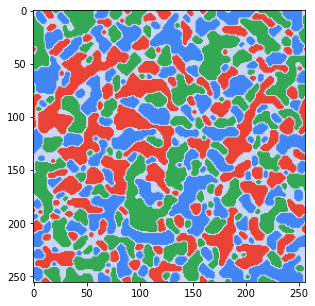

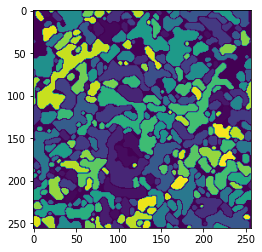

[9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 19, 19, 19, 19, 19, 21, 22, 22, 22, 23, 23, 24, 24, 24, 24, 25, 25, 25, 26, 26, 28, 28, 28, 29, 30, 31, 31, 33, 33, 34, 34, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 44, 45, 47, 47, 48, 49, 49, 49, 50, 50, 50, 50, 52, 52, 53, 53, 53, 54, 55, 56, 56, 56, 56, 60, 61, 62, 64, 64, 66, 66, 66, 68, 68, 70, 70, 70, 71, 72, 72, 72, 73, 74, 75, 75, 75, 75, 76, 77, 78, 78, 78, 79, 79, 80, 81, 83, 83, 84, 84, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 96, 97, 99, 99, 99, 100, 101, 104, 105, 106, 107, 107, 107, 110, 111, 113, 114, 114, 119, 120, 122, 125, 127, 129, 129, 132, 135, 136, 140, 145, 147, 147, 149, 149, 149, 151, 155, 159, 160, 162, 163, 167, 168, 169, 171, 171, 173, 174, 174, 175, 176, 177, 179, 180, 183, 183, 184, 187, 188, 188, 189, 191, 194, 194, 195, 198, 199, 199, 201, 202, 204, 205, 211, 213, 219, 232, 241, 243, 250, 256, 2

In [33]:
grid, clusters, cluster_sizes = create_grid(256,THR,p,seed,iw=0)

plt.imshow(clusters)
plt.show()

print(sorted(cluster_sizes))


In [28]:
cs = create_cluster_sizes([32,64], THR, p, seed=21, Nrep=64 )

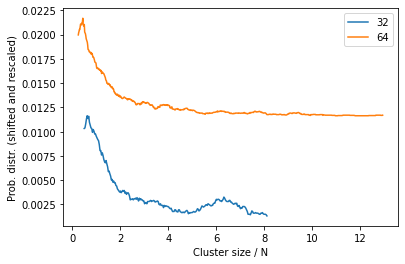

In [32]:
plot_cluster_sizes(cs, n=32, a=1000)
plt.show()